In [89]:
import warnings
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pandas.plotting import autocorrelation_plot


from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose




warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge. Check mle_retvals")

# Data Wrangling

In [90]:
#wrangle function

def wrangle(filepath, resample = '1H'):
    df = pd.read_csv(filepath, delim_whitespace=True)

    # Drop columns with QD as they are separators
    df = df.loc[:, ~df.columns.str.endswith('QD')]
    
    # Replace placeholder values with NaN
    df.replace(['//', '__', '---'], pd.NA, inplace=True)

    #convert time col into datetime type
    df["Time"] = pd.to_datetime(df["Time"])

    # Set the Time column as the index
    df.set_index("Time", inplace=True)

    #Convert the rest of columns to float type
    for column in df.columns:
        if column != "Time":
            df[column] = pd.to_numeric(df[column], errors='coerce')
    
    
    # Drop columns that have zero non-null values
    df.dropna(axis=1, how='all', inplace=True)

    #Drop columns with null values more than half of column
    for i in df.columns:
        if df[i].isnull().sum()>0.5* len(df[i]):
            df.drop(columns = i, inplace =True)
            
    # Convert the timezone to Europe/Athens
    df.index = df.index.tz_convert('Europe/Athens')

    df = df.resample(resample).mean().ffill()

    df.drop(columns=['CS','foF2'], inplace =True)


    y_train = df['2022-05-01':'2022-08-01']['TEC']
    
    # Slice the DataFrame for testing set
    y_test = df['2022-08-02':'2022-08-02']['TEC']
    
    y_train = pd.Series(y_train)
    y_test = pd.Series(y_test)

    return y_train,y_test

    

In [91]:
y_train,y_test= wrangle('DIDBGetValues(foF2,TEC)_edited.txt')
y_train.head()

Time
2022-05-01 00:00:00+03:00    4.025000
2022-05-01 01:00:00+03:00    4.418182
2022-05-01 02:00:00+03:00    3.225000
2022-05-01 03:00:00+03:00    4.100000
2022-05-01 04:00:00+03:00    3.541667
Freq: H, Name: TEC, dtype: float64

In [92]:
y_train.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2232 entries, 2022-05-01 00:00:00+03:00 to 2022-08-01 23:00:00+03:00
Freq: H
Series name: TEC
Non-Null Count  Dtype  
--------------  -----  
2232 non-null   float64
dtypes: float64(1)
memory usage: 34.9 KB


# Explore

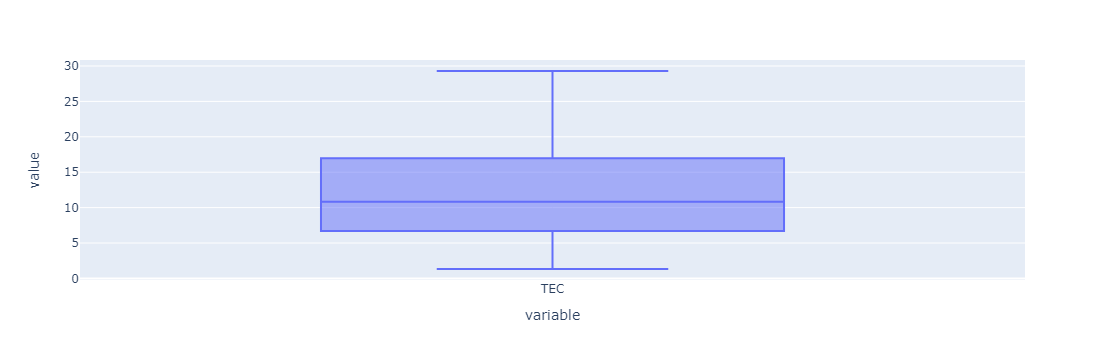

In [93]:
px.box(data_frame= y_train)

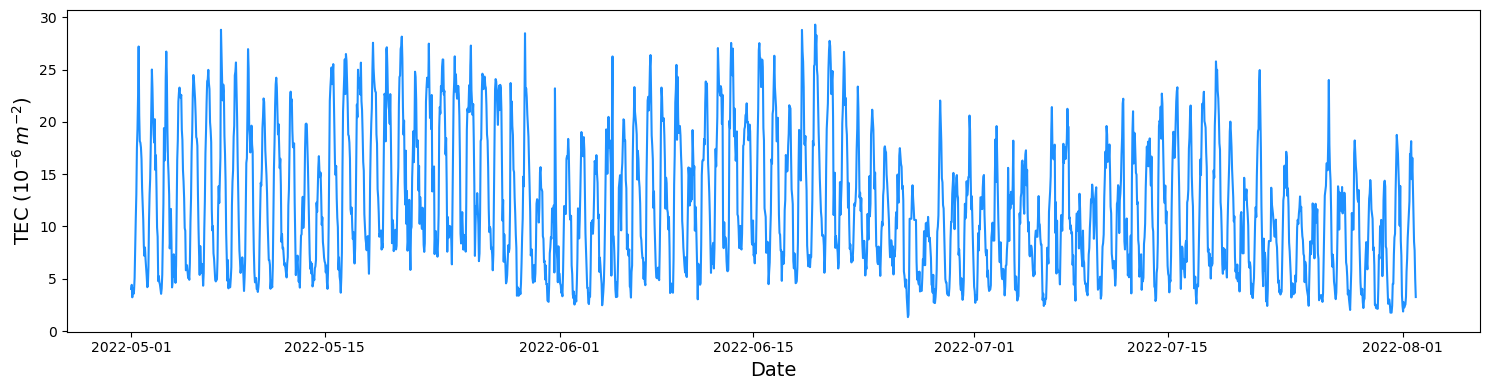

In [94]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

# Plot the Series
sns.lineplot(x=y_train.index, y=y_train.values, ax=ax, color='dodgerblue')

# Set labels
ax.set_ylabel(r'TEC ($10^{-6} \, m^{-2}$)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

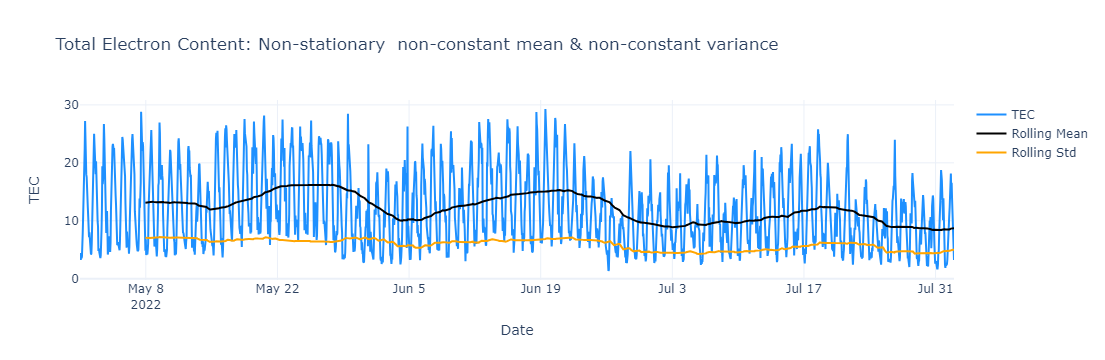

In [95]:

rolling_window = 168  # Number of hours in a week

# Calculate rolling mean and standard deviation
rolling_mean = y_train.rolling(window=rolling_window).mean()
rolling_std = y_train.rolling(window=rolling_window).std()

# Create a Plotly figure
fig = go.Figure()

# Add TEC time series
fig.add_trace(go.Scatter(x=y_train.index, y=y_train.values, mode='lines', name='TEC', line=dict(color='dodgerblue')))

# Add rolling mean
fig.add_trace(go.Scatter(x=y_train.index, y=rolling_mean, mode='lines', name='Rolling Mean', line=dict(color='black')))

# Add rolling std
fig.add_trace(go.Scatter(x=y_train.index, y=rolling_std, mode='lines', name='Rolling Std', line=dict(color='orange')))

# Update layout
fig.update_layout(
    title='Total Electron Content: Non-stationary \nnon-constant mean & non-constant variance',
    xaxis_title='Date',
    yaxis_title='TEC',
    template='plotly_white'
)


# ADF test

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [96]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result

# Apply ADF test
adf_result = adf_test(y_train)

# Extract results
adf_stat = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Print results (optional)
print(f'ADF Statistic: {adf_stat}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Statistic: -2.8628879067203807
p-value: 0.04983696582704958
Critical Values:
   1%: -3.433317781310122
   5%: -2.8628510732269983
   10%: -2.56746794802603


In [97]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=y_train.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

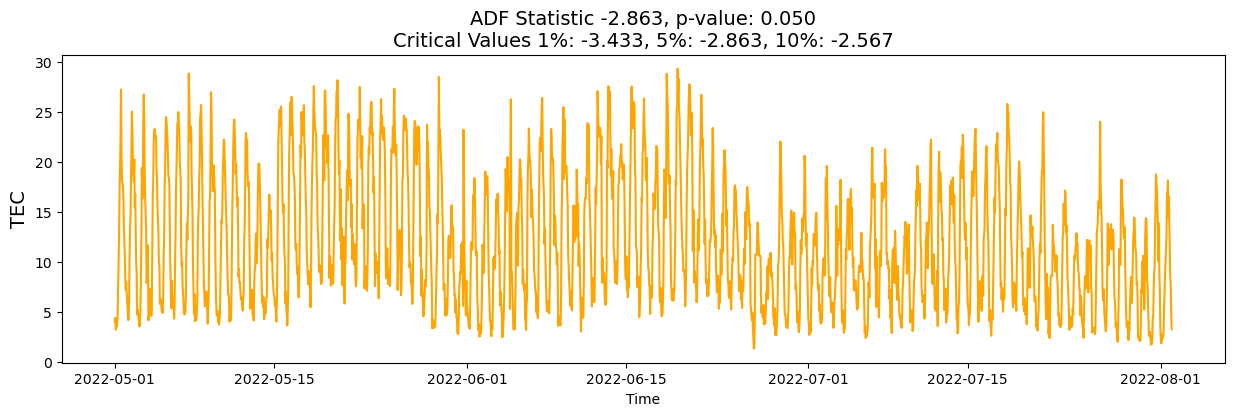

In [98]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

visualize_adfuller_results(y_train.values, 'TEC', ax=ax)

# TimeSeries Decomposition

In [99]:
decomp = seasonal_decompose(y_train, period=168, model='additive', extrapolate_trend='freq')
TEC_trend= decomp.trend
TEC_seasonal= decomp.seasonal

decomp_frame = pd.DataFrame({
    'Date': y_train.index,
    'TEC': y_train.values,
    'TEC_trend': TEC_trend,
    'TEC_seasonal': TEC_seasonal
})

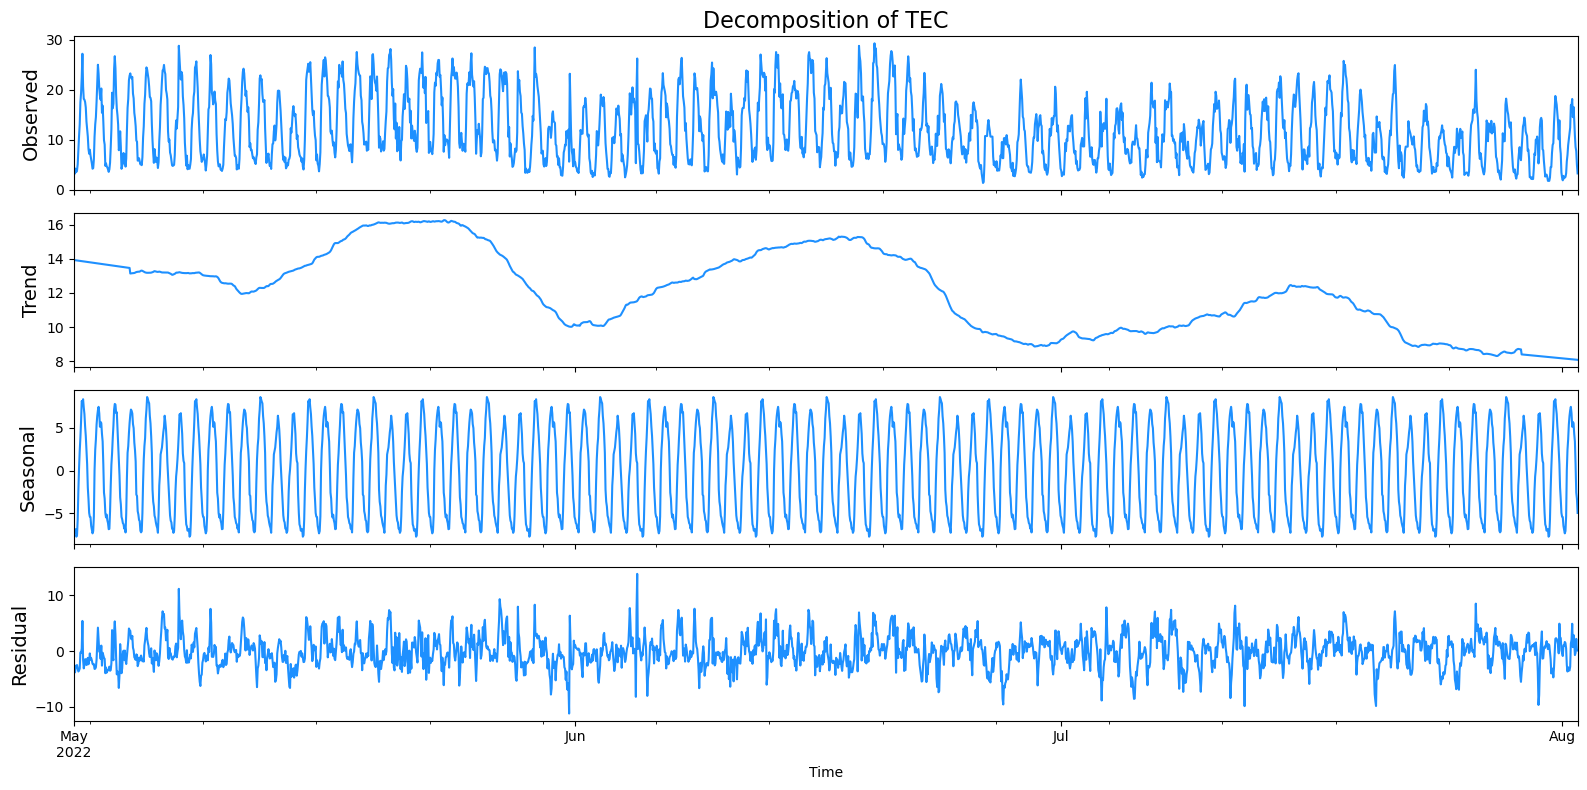

In [100]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16, 8))

# Column to decompose
column = 'TEC'  # Change this to the appropriate column name or Series variable

# Decompose the Series
res = seasonal_decompose(y_train, period=rolling_window, model='additive', extrapolate_trend='freq')

# Plot the results
ax[0].set_title('Decomposition of {}'.format(column), fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.tight_layout()

# Lag

In [101]:
days_in_week = 7

# Create shifted versions of the seasonal component for the 'TEC' column
decomp_frame['TEC_seasonal_shift_b_2w'] = decomp_frame['TEC_seasonal'].shift(-2 * days_in_week)
decomp_frame['TEC_seasonal_shift_b_1w'] = decomp_frame['TEC_seasonal'].shift(-1 * days_in_week)
decomp_frame['TEC_seasonal_shift_1w'] = decomp_frame['TEC_seasonal'].shift(1 * days_in_week)
decomp_frame['TEC_seasonal_shift_2w'] = decomp_frame['TEC_seasonal'].shift(2 * days_in_week)
decomp_frame['TEC_seasonal_shift_3w'] = decomp_frame['TEC_seasonal'].shift(3 * days_in_week)


In [102]:
decomp_frame.head()

,Date,TEC,TEC_trend,TEC_seasonal,TEC_seasonal_shift_b_2w,TEC_seasonal_shift_b_1w,TEC_seasonal_shift_1w,TEC_seasonal_shift_2w,TEC_seasonal_shift_3w
Time,,,,,,,,,
2022-05-01 00:00:00+03:00,2022-05-01 00:00:00+03:00,4.025000,13.929748,-6.541051,8.350461,-2.313329,NaN,NaN,NaN
2022-05-01 01:00:00+03:00,2022-05-01 01:00:00+03:00,4.418182,13.924126,-7.026572,7.386796,0.277196,NaN,NaN,NaN
2022-05-01 02:00:00+03:00,2022-05-01 02:00:00+03:00,3.225000,13.918505,-6.891583,6.615139,2.309526,NaN,NaN,NaN
2022-05-01 03:00:00+03:00,2022-05-01 03:00:00+03:00,4.100000,13.912883,-6.858894,5.161098,3.860375,NaN,NaN,NaN
2022-05-01 04:00:00+03:00,2022-05-01 04:00:00+03:00,3.541667,13.907261,-7.725718,4.059024,5.783594,NaN,NaN,NaN


# EDA

<Axes: xlabel='Time', ylabel='TEC_seasonal'>

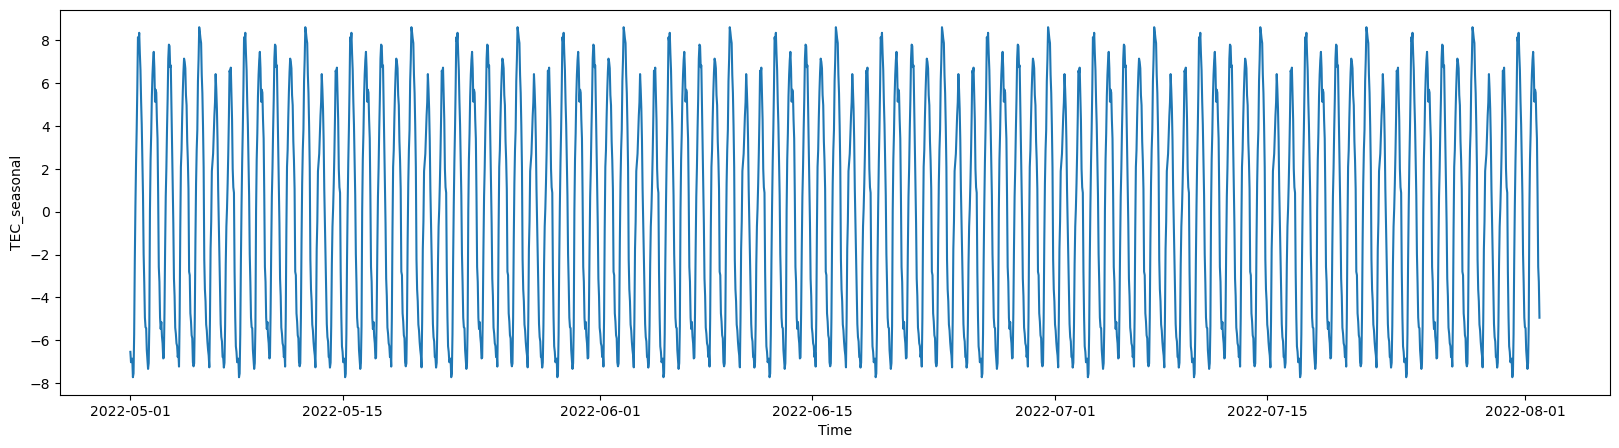

In [103]:
f, ax = plt.subplots(figsize=(20, 5))

sns.lineplot(data =decomp_frame, x= decomp_frame.index, y='TEC_seasonal', )
# ax.set_ylabel(ylabel=column, fontsize=14)


<Axes: >

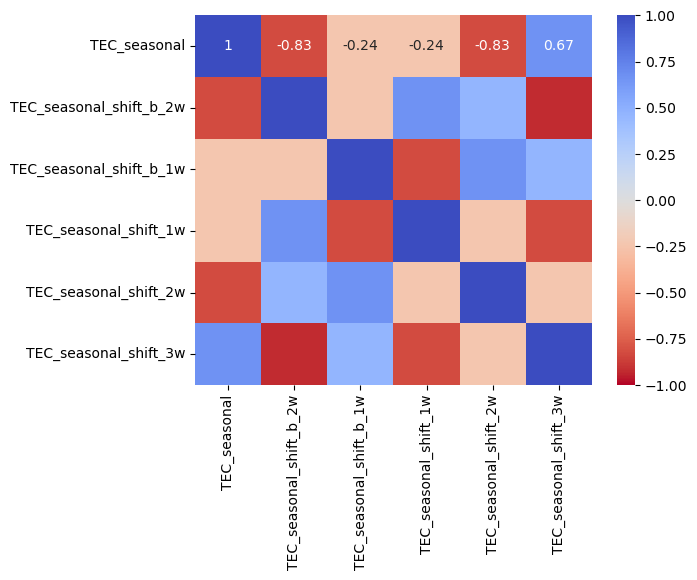

In [104]:
shifted_cols = [col for col in decomp_frame.columns if col not in ['TEC', 'TEC_trend', 'Date']]
corrmat = decomp_frame[shifted_cols].corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')


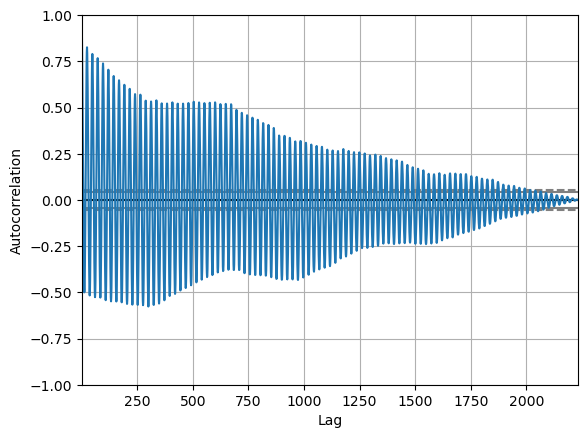

In [105]:
autocorrelation_plot(y_train.values);


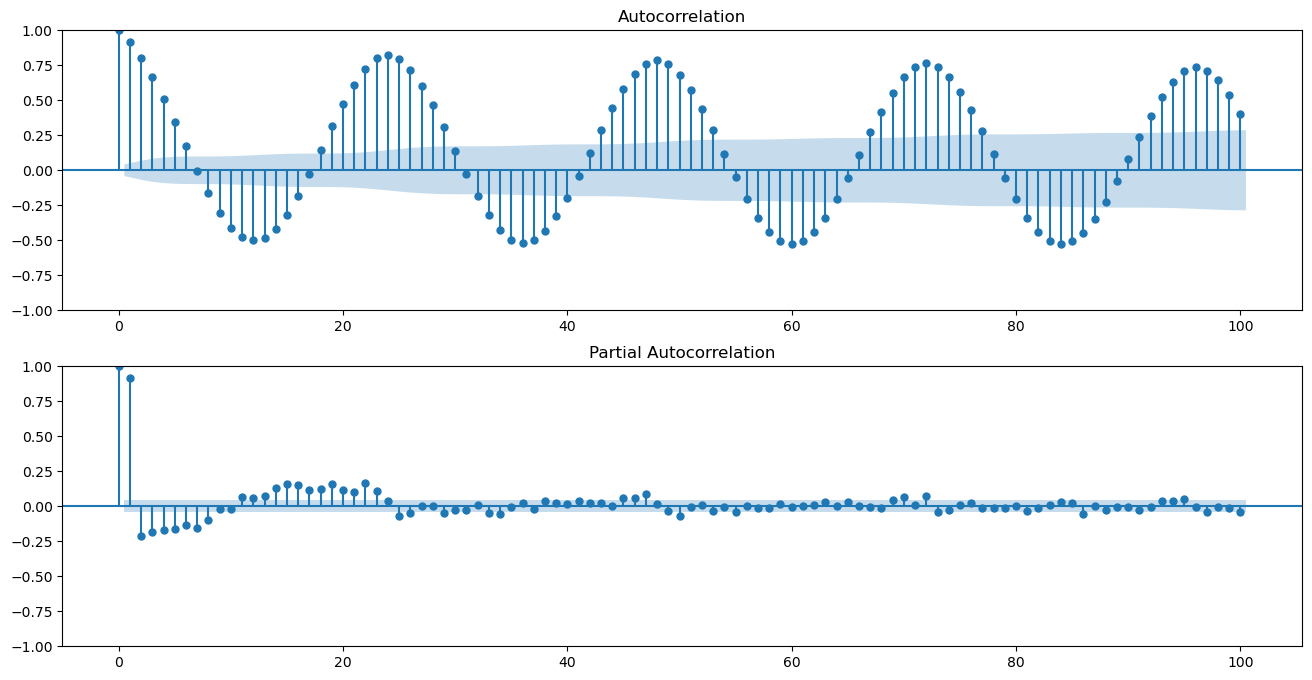

In [106]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(y_train, lags=100, ax=ax[0])
plot_pacf(y_train, lags=100, ax=ax[1]);

# Build Model

## Baseline

In [108]:
y_train_mean = y_train.mean()
y_pred_base= pd.Series([y_train.mean()] * len(y_train), index=y_train.index)
mae_baseline= mean_absolute_error(y_train,y_pred_base)
print("Mean TEC Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean TEC Reading: 12.04
Baseline MAE: 5.44


## AutoRegressive Model

In [109]:
model = AutoReg(y_train, lags=23).fit()
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[23:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 1.5899964426409035


In [110]:
y_train_resid = model.resid
y_train_resid.tail()

Time
2022-08-01 19:00:00+03:00   -2.226126
2022-08-01 20:00:00+03:00   -1.128744
2022-08-01 21:00:00+03:00    0.293081
2022-08-01 22:00:00+03:00   -1.216148
2022-08-01 23:00:00+03:00   -0.559540
Freq: H, dtype: float64

<Axes: xlabel='Time'>

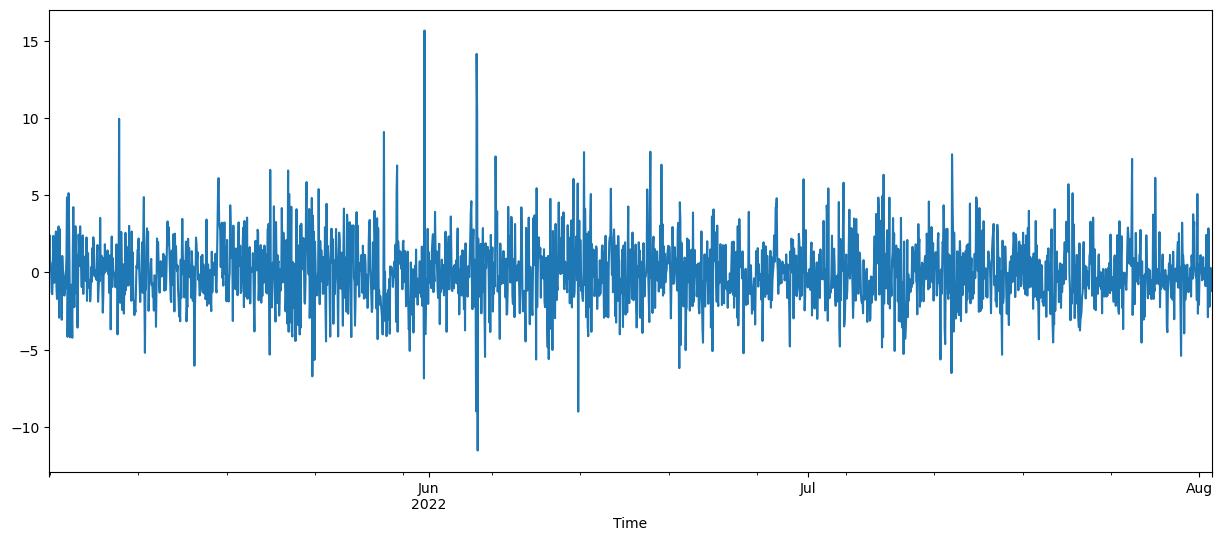

In [111]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot()

<Axes: >

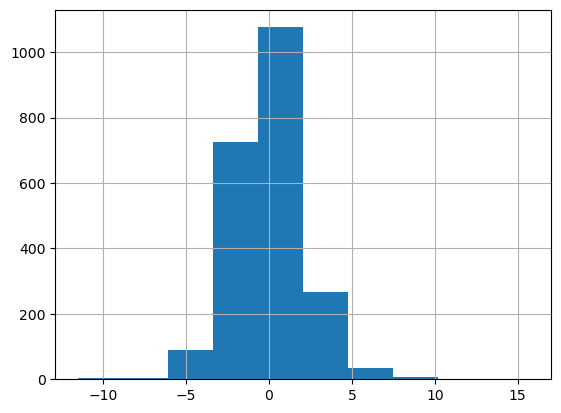

In [112]:
y_train_resid.hist()

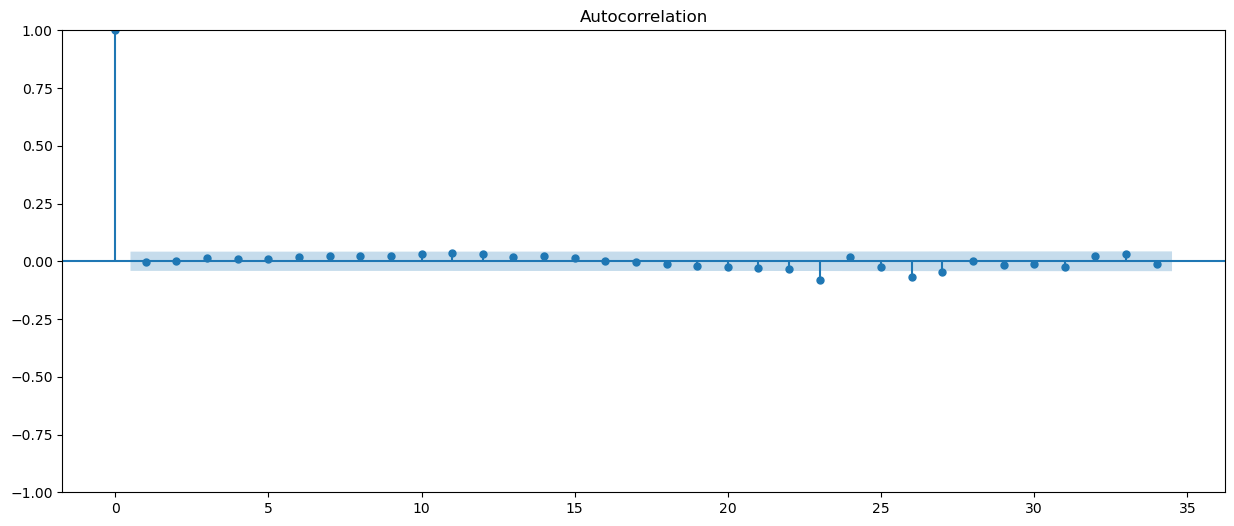

In [113]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

## Evaluate

In [114]:
y_test.index.min()

Timestamp('2022-08-02 00:00:00+0300', tz='Europe/Athens')

In [115]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 1.8857232182969819


In [116]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

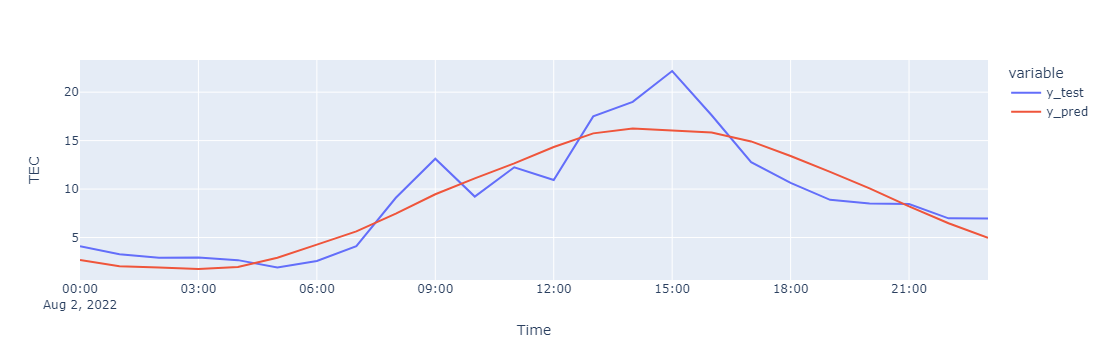

In [117]:
fig = px.line(df_pred_test, labels={"value": "TEC"})
fig.show()

In [118]:


# Assuming y_train and y_test are pandas Series with a DateTime index
y_pred_wfv = []
history = y_train.copy()

for i in range(len(y_test)):
    # Fit the AutoReg model on the current history
    model = AutoReg(history, lags=26).fit()
    
    # Forecast the next value
    next_pred = model.forecast(steps=1)
    
    # Append the forecasted value to the predictions list
    y_pred_wfv.append(next_pred[0])
    
    # Update the history with the actual value from y_test
    # next_pred.index is used to align with y_test index
    history = pd.concat([history, y_test[next_pred.index]])

# Convert the list of predictions to a Series
y_pred_wfv = pd.Series(y_pred_wfv, index=y_test.index)

y_pred_wfv.head()

Time
2022-08-02 00:00:00+03:00    2.620822
2022-08-02 01:00:00+03:00    3.113894
2022-08-02 02:00:00+03:00    2.934455
2022-08-02 03:00:00+03:00    2.545137
2022-08-02 04:00:00+03:00    2.846542
Freq: H, dtype: float64

In [119]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.64


## Results

In [120]:
print(model.params)

const      0.557151
TEC.L1     0.753468
TEC.L2    -0.004410
TEC.L3    -0.009086
TEC.L4     0.010126
TEC.L5     0.004113
TEC.L6     0.054088
TEC.L7    -0.018431
TEC.L8    -0.046357
TEC.L9     0.031794
TEC.L10   -0.054344
TEC.L11    0.017236
TEC.L12   -0.002561
TEC.L13   -0.043960
TEC.L14   -0.029631
TEC.L15    0.013585
TEC.L16    0.043833
TEC.L17    0.000008
TEC.L18   -0.015464
TEC.L19    0.060580
TEC.L20    0.047947
TEC.L21   -0.031615
TEC.L22    0.080957
TEC.L23    0.077047
TEC.L24    0.101630
TEC.L25   -0.031997
TEC.L26   -0.055705
dtype: float64


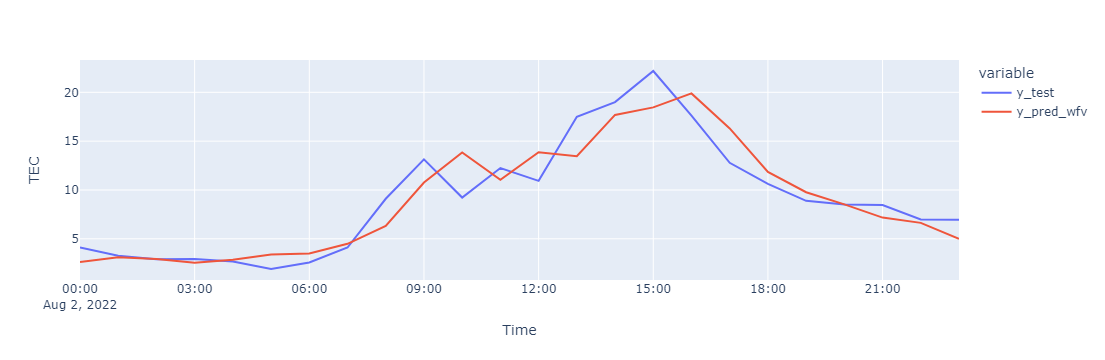

In [121]:
df_pred_test= pd.DataFrame({'y_test': y_test, 'y_pred_wfv':y_pred_wfv}, index= y_test.index)
fig = px.line(df_pred_test, labels={"value": "TEC"})
fig.show()

# ARIMA model

In [122]:
p_params = range(0,25,8)
q_params = range(0,3,1)

In [123]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.26 seconds.
Trained ARIMA (0, 0, 1) in 0.33 seconds.
Trained ARIMA (0, 0, 2) in 0.52 seconds.
Trained ARIMA (8, 0, 0) in 1.02 seconds.
Trained ARIMA (8, 0, 1) in 2.35 seconds.
Trained ARIMA (8, 0, 2) in 2.59 seconds.
Trained ARIMA (16, 0, 0) in 4.49 seconds.
Trained ARIMA (16, 0, 1) in 10.76 seconds.
Trained ARIMA (16, 0, 2) in 12.35 seconds.
Trained ARIMA (24, 0, 0) in 20.7 seconds.
Trained ARIMA (24, 0, 1) in 18.86 seconds.
Trained ARIMA (24, 0, 2) in 28.99 seconds.

{0: [5.439061536570066, 3.3964800773746284, 2.6110601735139736], 8: [1.7669038376098223, 1.7669595915122722, 1.7684750918087184], 16: [1.7102648451555376, 1.6380780481468842, 1.640432512781451], 24: [1.5898324788959313, 1.588700017476983, 1.5846602301143036]}


In [124]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,5.4391,1.7669,1.7103,1.5898
1,3.3965,1.7670,1.6381,1.5887
2,2.6111,1.7685,1.6404,1.5847


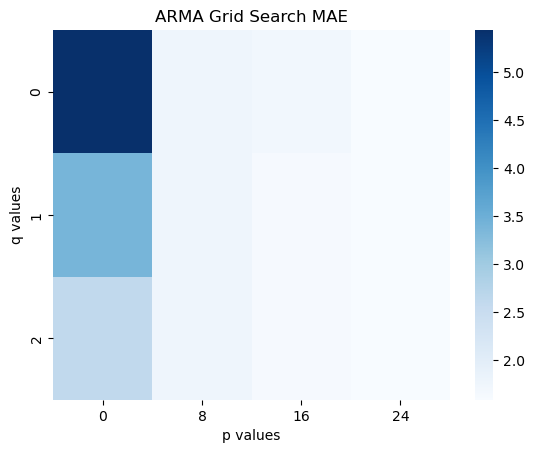

In [125]:
sns.heatmap(mae_df, cmap= 'Blues')
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('ARMA Grid Search MAE');

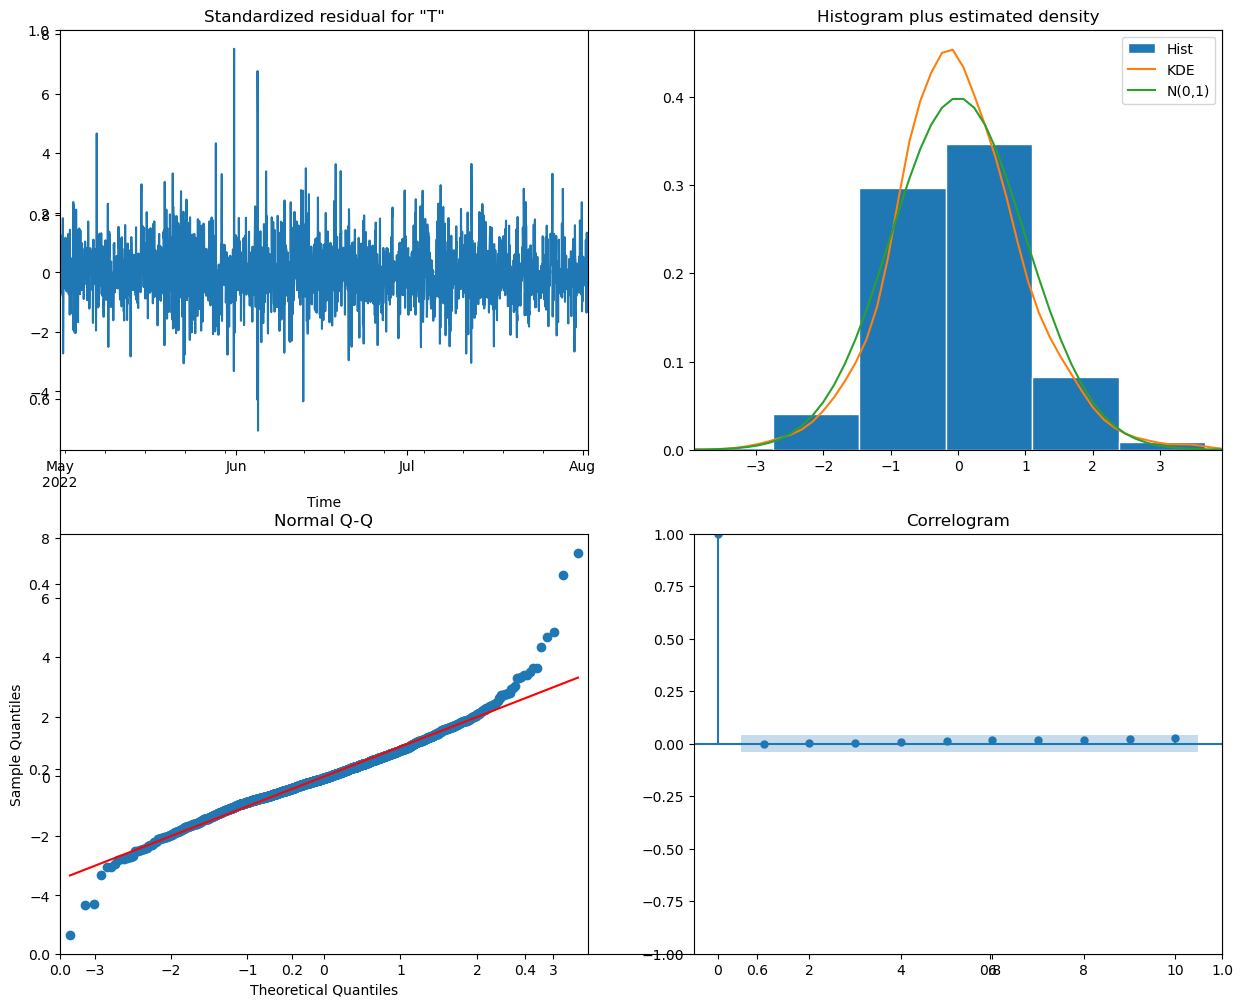

In [126]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

In [127]:
# Example of using a simpler ARIMA model
y_pred_wfv = []
history = y_train.copy()

# Iterate over test data
for i in range(len(y_test)):
    try:
        model = ARIMA(history, order=(24, 0, 2)).fit(method_kwargs={"maxiter": 200})  # Increase iterations
        next_pred = model.forecast()
        y_pred_wfv.append(next_pred.iloc[0])  # Append the prediction to the list
        history = pd.concat([history, y_test[next_pred.index]])  # Concatenate the history with the new data point
    except Exception as e:
        print(f"Error at iteration {i}: {e}")
        y_pred_wfv.append(history.iloc[-1])  # Fallback to last value in history

# Convert the list of predictions to a Series
y_pred_wfv = pd.Series(y_pred_wfv, index=y_test.index)


In [128]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.64


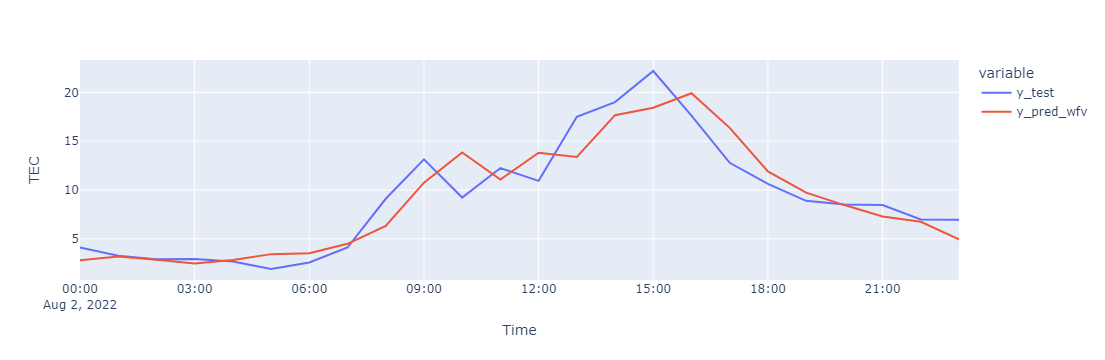

In [129]:
df_predictions = pd.DataFrame({'y_test': y_test, 'y_pred_wfv': y_pred_wfv}, index= y_test.index)
fig = px.line(df_predictions, labels={"value": "TEC"})
fig.show()